## MNIST

In this chapter, we will be using the MNIST dataset, which is a set of 70,000 small
images of digits handwritten by high school students and employees of the US Census
Bureau. Each image is labeled with the digit it represents

In [1]:
from sklearn.datasets import fetch_mldata
mnist= fetch_mldata("MNIST original")
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [2]:
X,y=mnist["data"],mnist["target"]
X.shape,y.shape

((70000, 784), (70000,))

X and y are respectively the samples and labels

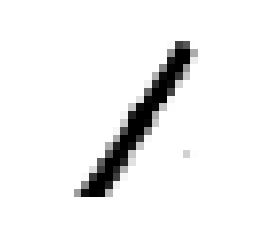

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit=X[10000]  #the 36000 sample

def plot_digit(X):
    some_digit_image=X.reshape(28,28)
    plt.imshow(some_digit_image,cmap = matplotlib.cm.binary)
    plt.axis("off") #close the axis number
    plt.show()
    
plot_digit(some_digit)

It looks like number 5

In [4]:
y[10000]

1.0

no doubt that the same as label

The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images):

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Moreover, some learning
algorithms are sensitive to the order of the training instances, and they perform
poorly if they get many similar instances in a row

In [6]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train,y_train=X_train[shuffle_index],y_train[shuffle_index]

## Training a Binary Classifier

build a binary classifier which can only classify the 5 and others

In [7]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits. output bool value
y_test_5 = (y_test == 5)
y_train_5

array([ True, False, False, ..., False, False, False], dtype=bool)

In [8]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=10) #random_state=10 is to set up the random seed tp make sure results reproducible  
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=10, shuffle=True, verbose=0,
       warm_start=False)

In [9]:
sgd_clf.predict([some_digit])

array([False], dtype=bool)

The classifier guesses right

In [10]:
y_train_pred=sgd_clf.predict(X_train)

## Performance Measures

### Measuring Accuracy Using Cross-Validation

Firstly we can use cross validation to evaluate the SGDClassifier

In [11]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy") #accuracy: n_correct / len(y_pred) (预测与实际label相符的比例)
scores

array([ 0.9448,  0.9634,  0.9527])

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
      def fit(self, X, y=None):
        pass
      def predict(self, X):
        return np.zeros((len(X), ), dtype=bool)  #len() output the list elements, in a matrix output the rows

the predict function return the vector full of false which length equals to X_test_fold

In [13]:
never_5_clf = Never5Classifier()

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(never_5_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    #y_test_fold.reshape(y_pred.shape[0],y_pred.shape[1])
    print(len(X_test_fold))   #len() output the list elements, in a matrix output the rows
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct)
    print(n_correct / len(y_pred))

20000
18193
0.90965
20000
18193
0.90965
20000
18193
0.90965


In [14]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")  

array([ 0.9084 ,  0.9129 ,  0.90765])

then let's apply the confusion matrix

In [15]:
from sklearn.metrics import confusion_matrix 
confusion_matrix(y_train_5,y_train_pred)

array([[53910,   669],
       [ 1154,  4267]])

at first row, 54200 non-5 cases are correctly classified as non-5, 280 cases non-5 are wrongly classified as 5

In [16]:
from sklearn.metrics import precision_score, recall_score,f1_score
precision_score(y_train_5,y_train_pred)

0.86446515397082657

In [17]:
recall_score(y_train_5,y_train_pred)

0.7871241468363771

In [34]:
f1_score(y_train_5,y_train_pred)

0.82398377908660814

In [18]:
from sklearn.model_selection import cross_val_predict
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,  #the scores are decision scores which decided the decision boundary
method="decision_function")
y_scores

array([ 381711.52706182, -440413.95614952, -860932.36668886, ...,
       -399015.26854709, -278262.47873223, -120224.77705212])

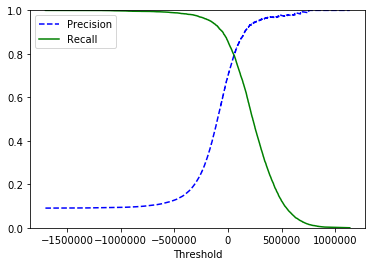

In [19]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
    

In [20]:
y_train_pred_90 = (y_scores > 70000)  #precision is more than 90%
precision_score(y_train_5, y_train_pred_90)

0.81207794713486403

In [21]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
thresholds

array([ 1136635.01822422,   753611.65994506,   752440.33665788, ...,
       -1702245.57322144, -1703143.94580417, -2753558.89716908])

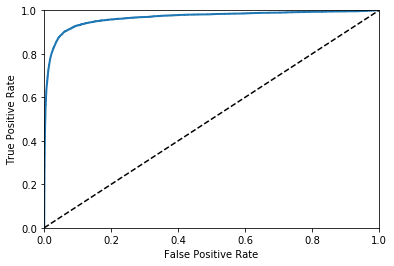

In [22]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

then we can calculate the area under the curve (UNA) 

In [23]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.96601414055830681

if perfect classifier , the UNA score will be the 1

then let us try to plot the ROC of another model: RandomForest

In [24]:
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(random_state=42)
y_proba_forest=cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")
y_proba_forest

array([[ 0.2,  0.8],
       [ 1. ,  0. ],
       [ 1. ,  0. ],
       ..., 
       [ 1. ,  0. ],
       [ 1. ,  0. ],
       [ 1. ,  0. ]])

In [25]:
y_scores_forest=y_proba_forest[:,1] #scores equal to the probability of positive elements
y_scores_forest

array([ 0.8,  0. ,  0. , ...,  0. ,  0. ,  0. ])

In [26]:
fpr_forest, tpr_forest , thresholds_forest= roc_curve(y_train_5,y_scores_forest)

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\legend.py:326: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  six.iterkeys(self.codes))))


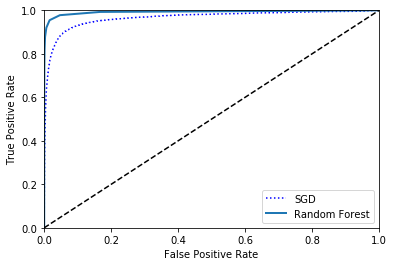

In [27]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

from the plot it is obvious that Random Forest is better than the SGD because it is close to the top-left corner which Ptp is 1.0,Pfp is 0.

In [28]:
roc_auc_score(y_train_5,y_scores_forest)

0.99266586079997998

and the AUC is larger as well

## Multiclass Classification

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass
classification task, and it automatically runs OvA (except for SVM classifiers for
which it uses OvO).

Let's try SGDClassifier

In [29]:
sgd_clf.fit(X_train,y_train) #not y_train_5
sgd_clf.predict([some_digit])

array([ 1.])

seems easy to implement multiclass classification using SGDClassifier

In [30]:
digit_scores=sgd_clf.decision_function([some_digit])
digit_scores

array([[-452452.03776392,  210351.05215167, -162088.79692871,
        -150560.54077552, -282484.99200533, -267901.12124722,
        -293712.38562549, -261242.40882177, -226817.44876697,
        -325810.76373902]])

In [31]:
np.argmax(digit_scores)

1

The maximum value's index is 5

In [32]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

Then we try the OvO classifier

In [33]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf=OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train,y_train)
ovo_clf.predict([some_digit])

KeyboardInterrupt: 

In [ ]:
len(ovo_clf.estimators_)

there are 45 classifiers at total

then let us try multi-classifier on the Randomtree

In [ ]:
forest_clf.fit(X_train,y_train)
forest_clf.predict([some_digit])

In [ ]:
forest_clf.predict_proba([some_digit])   #forest_clf does not have decision_function

0.8 means that the probability of 5 of this digit is 0.8, there are still some probabilities to be other digits

Next: we will evaluate these classifier using cross_val_score

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))  #X_train is uint8,should be trainsform into float64
X_train_scaled

In [ ]:
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

Compared with non-scaled, the accuracy is improved

## Error Analysis 

In [ ]:
y_train_pred=cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx=confusion_matrix(y_train,y_train_pred)

In [ ]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

it seems good because most of samples concentrate on the diagnol

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums

In [ ]:
norm_conf_mx=conf_mx/row_sums
norm_conf_mx

fill diagonal with zero and only plot the errors

In [ ]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

the columns 8 and 9 is brighter than others means many digits are misclassified as 8 and 9. From the servral bright blocks we can find that number 3 is often misclassified as 5, 5 is often misclassified as 3, and 7 is often misclassified as 9

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabels Classification

In [ ]:
y_train

in Multilabels Classification, the samples not only labeled as one class, so we use KNeighborsClassifier to apply

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

y_multilabel = np.c_[y_train_large, y_train_odd]
print(y_multilabel)
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit])

some_digit is 5 , it shouldn't be lager than 7 and it is odd , so correct

then let us predict and compute the F1 scores to evaluate

In [ ]:
#y_train_knn_pred=cross_val_predict(knn_clf,X_train,y_train,cv=3)
#f1_score(y_train,y_train_knn_pred,average="Marco")

## Multioutput Classification

Here we create a denoise system as example of Multioutput Classification(Multilabels Multiclass probelm) we input a noised image and output a denoised image, the output is multilabels(a label per pixel) and each pixel or each label has multiclasses( 0 to 255)

In [ ]:
len(X_train)

In [ ]:
noise_train = np.random.randint(0, 100, (len(X_train), 784))
noise_test = np.random.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise_train
X_test_mod = X_test + noise_test
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
plot_digit(X_train_mod[36000])

In [ ]:
plot_digit(y_train_mod[36000])

then we use the KNN classifier to solve

In [ ]:
knn_clf.fit(X_train_mod,y_train_mod)

In [ ]:
some_knn_predict_digit=knn_clf.predict(X_test_mod[3000])
plot_digit(X_test_mod[3000])

Nice work It's close enough 

## Exersice 1 

let us see the acurrency using KNeighbor before GridSearch

In [ ]:
knn_clf.fit(X_train_scaled,y_train)
y_test_pred=knn_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test_pred)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid=[{"weights":['uniform','distance'],'n_neighbors':[4,5]}]
grid_search=GridSearchCV(knn_clf,param_grid,cv=3,verbose=3)
grid_search.fit(X_train_scaled,y_train)

In [ ]:
grid_search.best_estimator_

then we use the test set

In [ ]:
from sklearn.metrics import accuracy_score
y_grid_pred=grid_search.predict(X_test)
accuracy_score(y_test, y_grid_pred)

it is too low because X_test shoul be scaled

In [ ]:
X_test_scaled=scaler.fit_transform(X_test.astype(np.float64))
y_grid_pred=grid_search.predict(X_test_scaled)
accuracy_score(y_test, y_grid_pred)

good!

## Exercise 2 Data Augmentation

In [ ]:
from scipy.ndimage.interpolation import shift

In [ ]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant") 
    #cval=Value used for points outside the boundaries of the input if mode='constant'. Default is 0.0
    #mode=Points outside the boundaries of the input are filled according to the given mode 
    #mode=(‘constant’, ‘nearest’, ‘reflect’ or ‘wrap’). Default is ‘constant’
    return shifted_image.reshape([-1]) #reshape([-1]) multipy all the dimensions 28*28=784

In [ ]:
image=X_train[1000]
image.shape

In [ ]:
image_down=shift_image(image,0,5)
image_left=shift_image(image,-5,0)

In [ ]:
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Shift_left", fontsize=14)
plt.imshow(image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Shift_down", fontsize=14)
plt.imshow(image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

this is data augmentation for just one sample,and we will apply this on the whole set

In [ ]:
%save output repr(_92)

In [ ]:
%save output repr(_60)

In [ ]:
#X_train_augmented = [image for image in X_train] #transfer the array in to the list
#y_train_augmented = [label for label in y_train]
y_train_augmented=list(y_train)
X_train_augmented=list(X_train)
y_train_augmented

In [ ]:

dx,dy =(2,0)
for image, label in zip(X_train_augmented,y_train_augmented):
    X_train_augmented.append(shift_image(image,dx,dy))
    y_train_augmented.append(label)
        
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shullfe_id=np.random.permutation(len(X_train_augmented))
X_train_augmented=X_train_augmented[shullfe_id]
y_train_augmented=y_train_augmented[shullfe_id]


In [ ]:
knn_clf=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance') #saved grid_search best estimator

In [ ]:
knn_clf.fit(X_train_augmented,y_train_augmented)

In [ ]:
y_pred=knn_clf.predict(X_test)
from sklearn.metrics import accuracy_score
y_augmented_pred=knn_clf.predict(X_test)
accuracy_score(y_test, y_augmented_pred)